<a href="https://colab.research.google.com/github/dwr-psandhu/nb-water/blob/master/CDEC_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDEC Data Retrieval
CDEC is the California Data Exchange Center which provides a service for hydrologic and water quality data retrieval. This notebook demonstrates how to retrieve that data and plot it.
It also demos simple filling of data and identifying tidal features such as high and low timings.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
#import matplotlib
#import plotly
#print(pd.__version__, np.__version__, matplotlib.__version__, plotly.__version__)

## CDEC Data Retrieval

CDEC data retrieval needs a station id and senor number with duration code and a start and end time date (keep these narrow, less than a year)

In [0]:
#@title CDEC Station Id
#@markdown See http://cdec.water.ca.gov/cdecstation2/ to get the three digit code
station_id = 'MRZ'  #@param {type: "string"}
sensor_num = '1' #@param {type: "string"}
dur_code='H' #@param {type: "string"}
start = '2019-08-01'  #@param {type: "date"}
end = '2019-09-21'  #@param {type: "date"}
#pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
#select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


Pull CDEC data into a pandas DataFrame

In [3]:
url=f'http://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={station_id}&SensorNums={sensor_num}&dur_code={dur_code}&Start={start}&End={end}'
print(url)
df=pd.read_csv(url,index_col='DATE TIME',parse_dates=True,dtype={'VALUE':np.float64},na_values={'VALUE':'---'})
display(df.head())
dfv=df.VALUE

http://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=MRZ&SensorNums=1&dur_code=H&Start=2019-08-01&End=2019-09-21


,STATION_ID,DURATION,SENSOR_NUMBER,SENSOR_TYPE,OBS DATE,VALUE,DATA_FLAG,UNITS
DATE TIME,,,,,,,,
2019-08-01 00:00:00,MRZ,H,1,RIV STG,20190801 0000,5.80,,FEET
2019-08-01 01:00:00,MRZ,H,1,RIV STG,20190801 0100,6.47,,FEET
2019-08-01 02:00:00,MRZ,H,1,RIV STG,20190801 0200,6.87,,FEET
2019-08-01 03:00:00,MRZ,H,1,RIV STG,20190801 0300,6.93,,FEET
2019-08-01 04:00:00,MRZ,H,1,RIV STG,20190801 0400,6.65,,FEET


Interactive plot using Plotly

In [4]:
data = [
    go.Scatter(
        x=dfv.index,
        y=dfv.values,
        name='MRZ: Stage'
    )
]
iplot(data)


## Filling in Missing Values
Lets do fill in using pandas interpolate

In [5]:
dfvis=dfv.interpolate(method='cubic')

data = [
    go.Scatter(
        x=dfvis.index,
        y=dfvis.values,
        name='MRZ-SPLINE',
        opacity=0.8,
        marker={'symbol':0}
    ),
    go.Scatter(
        x=dfv.index,
        y=dfv.values,
        name='MRZ'
    ),

]
iplot(data)

In [6]:
dfv=dfvis
dx=np.gradient(dfv.values)
diffdfv=pd.Series(dx,index=dfv.index)
d2x=np.gradient(dx)
diff2dfv=pd.Series(d2x,index=dfv.index)

data = [
    go.Scatter(
        x=dfv.index,
        y=dfv.values,
        name="MRZ-FILLED"
    ),
    go.Scatter(
        x=diffdfv.index,
        y=diffdfv.values,
        name="1st Derivative"
    ),
    go.Scatter(
        x=diff2dfv.index,
        y=diff2dfv.values,
        name="2nd Derivative"
    )

]
iplot(data)

# Calculate timing for high-high, high-low, low-high, low-lows
These can be calculated using zero crossing logic on the discrete time series. The 1st derivative changes sign on each of these and those times need to be calculated using linear interpolation.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



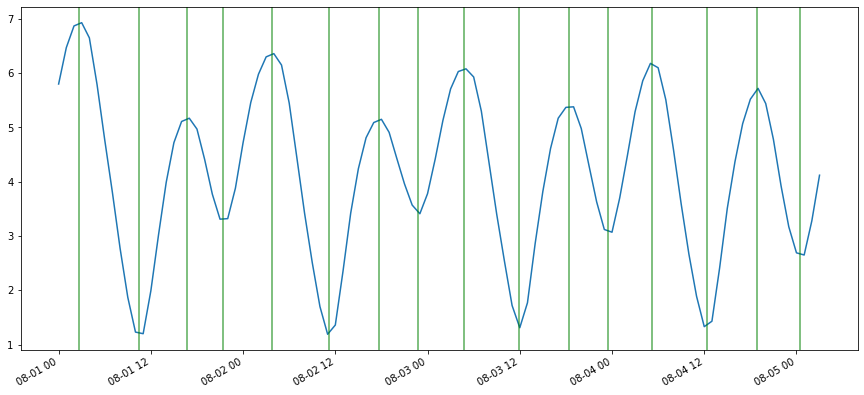

In [7]:
diffdfv
indi=np.where(np.diff(np.sign(diffdfv)))[0]
# Find the zero crossing by linear interpolation
zdb=diffdfv[indi].index
zda=diffdfv[indi+1].index
x=diffdfv.index
y=diffdfv.values
dx = x[indi+1] - x[indi]
dy = y[indi+1] - y[indi]
zc = -y[indi] * (dx/dy) + x[indi]
# Plot the data
fig=plt.figure(figsize=(15,7))
s=slice(0,100)
plt.plot(dfv[s])#, 'b.-')
fig.autofmt_xdate()
# Add black points where the zero line is crossed
zds=zc<max(dfv[s].index)
for v in zc[zds]:
  plt.axvline(v,color='green',alpha=0.66)

In [8]:
!pip install PyAstronomy #-- if not already run. If the next line fails, uncomment and run this

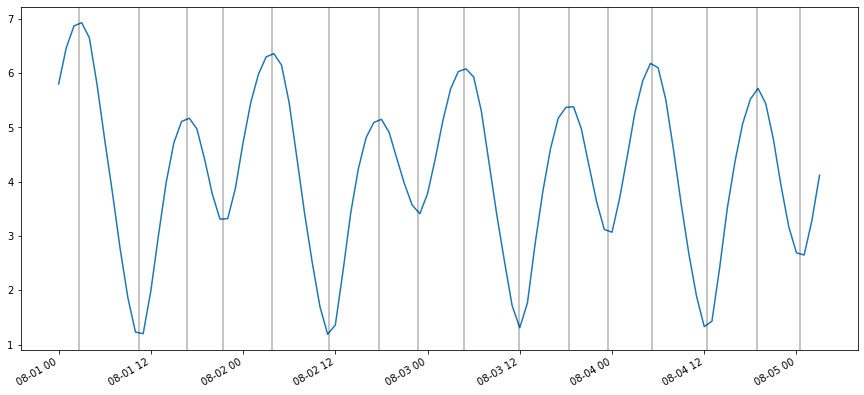

In [9]:
from PyAstronomy.pyaC import zerocross1d
zc,zi=zerocross1d(diffdfv.index.astype(np.int64), diffdfv.values, getIndices=True)
zd=pd.to_datetime(zc)
# Plot the data
fig=plt.figure(figsize=(15,7))
s=slice(0,100)
plt.plot(dfv[s])#, 'b.-')
fig.autofmt_xdate()
# Add black points where the zero line is crossed
zds=zd<max(dfv[s].index)
for v in zd[zds]:
  plt.axvline(v,color='black',alpha=0.3)


#Autocorrelation
Calculate and plot autocorrelation of time series. Should show a repeating pattern for tidal data.

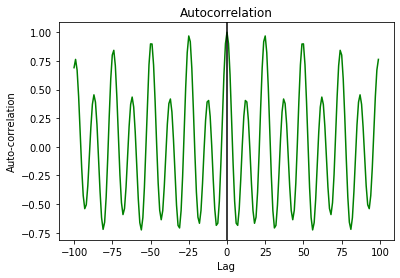

In [10]:
lag=np.array(range(-100,100)) #
#np.array([f(xi) for xi in x])
corr=np.array([dfv.autocorr(l) for l in lag])
plt.title(label="Autocorrelation")
plt.plot(lag,corr,color='green')
plt.xlabel("Lag")
plt.ylabel("Auto-correlation")
plt.axvline(0,color='black')

# Use rolling window to get tidal highs and lows
We can take advantage of the fact that a tidal signal is 25 hours and the tide is semi-diurnal, i.e. there will be a high and low within a 7 hour window

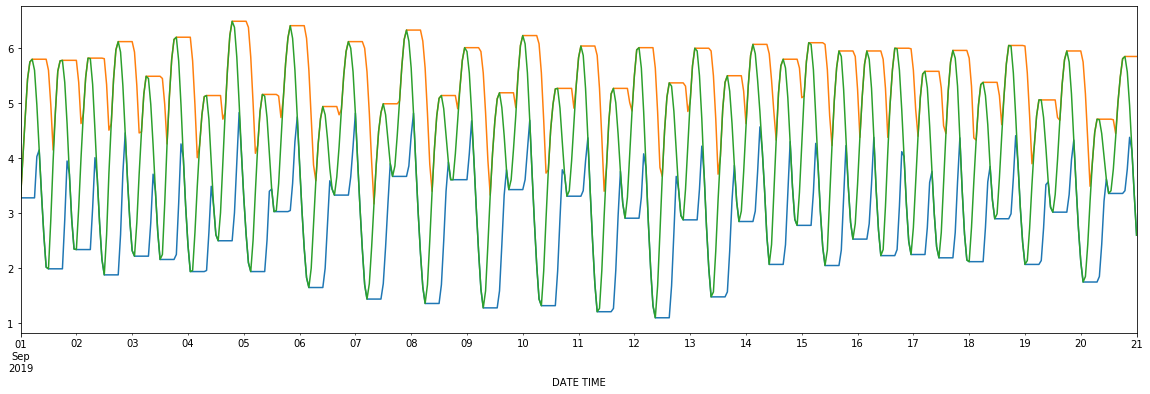

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[20,6]
tstidal=dfv['SEP2019']
ax1=tstidal.rolling('7H').min().plot()
tstidal.rolling('7H').max().plot(ax=ax1)
tstidal.plot(ax=ax1)
